In [1]:
# ================== CELL 1: SETUP + LOAD (KAGGLE, 1k ratings) ==================
# Installs (quiet). Kaggle allows this and it’s fast.
!pip -q install mlxtend

import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# Paths
INPUT_DIR  = "/kaggle/input/datagg"      # <- your dataset folder
WORK_DIR   = "/kaggle/working"
FIGS_DIR   = os.path.join(WORK_DIR, "figs")
os.makedirs(FIGS_DIR, exist_ok=True)

# Try to locate files inside the dataset folder
def find_csv(folder, hint):
    cands = glob.glob(os.path.join(folder, "*.csv"))
    # prefer filenames that contain the hint
    cands_hint = [p for p in cands if hint.lower() in os.path.basename(p).lower()]
    return (cands_hint[0] if cands_hint else (cands[0] if cands else None))

movies_path  = find_csv(INPUT_DIR, "movie")
ratings_path = find_csv(INPUT_DIR, "rating")

assert movies_path and ratings_path, f"Could not find movies/ratings CSVs in {INPUT_DIR}. Found: {movies_path}, {ratings_path}"

# Load
movies  = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)

# Keep expected columns if present
movies = movies.rename(columns={c:c.strip() for c in movies.columns})
ratings = ratings.rename(columns={c:c.strip() for c in ratings.columns})
keep_movies  = [c for c in ["movieId","title","genres"] if c in movies.columns]
keep_ratings = [c for c in ["userId","movieId","rating","timestamp"] if c in ratings.columns]
movies  = movies[keep_movies].dropna(subset=[keep_movies[0]])
ratings = ratings[keep_ratings].dropna(subset=[keep_ratings[0]])

# ---- Subsample EXACTLY 1,000 ratings for speed (reproducible) ----
RANDOM_SEED = 42
N_SAMPLE = 1_000
if len(ratings) > N_SAMPLE:
    ratings_1k = ratings.sample(n=N_SAMPLE, random_state=RANDOM_SEED).sort_values(keep_ratings[-1] if "timestamp" in keep_ratings else keep_ratings[0])
else:
    ratings_1k = ratings.copy()

# ---- Likes (threshold only; TRUE "no preprocessing" beyond this) ----
LIKE_THRESHOLD = 4.0
likes = ratings_1k[ratings_1k["rating"] >= LIKE_THRESHOLD].merge(movies, on="movieId", how="left")

# ----------------- Build baskets for visuals -----------------
# 1) GENRE baskets: one row per user, columns = genres (1/0)
if "genres" in movies.columns:
    genres_expanded = (
        likes.assign(genres=likes["genres"].astype(str).str.split("|"))
             .explode("genres")
             .dropna(subset=["genres"])
    )
    user_genre = (genres_expanded.groupby(["userId","genres"])["movieId"].count().reset_index(name="count"))
    genre_baskets = (user_genre.assign(val=1)
                                .pivot_table(index="userId", columns="genres", values="val", fill_value=0)
                                .astype("int8"))
else:
    genre_baskets = pd.DataFrame()
    
# 2) MOVIE baskets (limit to top-K in this 1k sample to keep it dense)
TOP_K_MOVIES = 120
movie_like_counts = (likes.groupby(["movieId"]).size().reset_index(name="n_like").sort_values("n_like", ascending=False))
top_movies = movie_like_counts.head(TOP_K_MOVIES)["movieId"].tolist()
likes_top = likes[likes["movieId"].isin(top_movies)].copy()
user_movie = (likes_top.assign(val=1)
                       .pivot_table(index="userId", columns="movieId", values="val", fill_value=0)
                       .astype("int8"))

# Small sanity Apriori/FP-Growth just to guarantee downstream visuals have inputs.
# (Params are mild for a tiny sample; we’ll do final visuals in the next cells.)
genre_freq = pd.DataFrame()
genre_rules = pd.DataFrame()
if not genre_baskets.empty:
    genre_freq = apriori(genre_baskets, min_support=0.04, use_colnames=True)  # small sample → slightly lower support
    genre_rules = association_rules(genre_freq, metric="confidence", min_threshold=0.30)
    genre_rules = genre_rules[genre_rules["lift"] >= 1.10]

movie_freq = fpgrowth(user_movie, min_support=0.02, use_colnames=True)
movie_rules = association_rules(movie_freq, metric="confidence", min_threshold=0.25)
movie_rules = movie_rules[movie_rules["lift"] >= 1.10]

# Id→title map for later readability (visual cells will add names)
id2title = dict(zip(movies.get("movieId", pd.Series(dtype=int)),
                    movies.get("title",  pd.Series(dtype=str))))

# Save lightweight CSVs for the next cells (so visuals never recompute)
genre_freq.to_csv(os.path.join(WORK_DIR, "genre_frequent_itemsets.csv"), index=False)
genre_rules.to_csv(os.path.join(WORK_DIR, "genre_association_rules.csv"), index=False)
movie_rules.to_csv(os.path.join(WORK_DIR, "movie_association_rules_topK_raw.csv"), index=False)

# Summary printout
print("=== LOAD SUMMARY (Kaggle, 1k ratings) ===")
print(f"Movies CSV:   {os.path.basename(movies_path)}  -> {movies.shape}")
print(f"Ratings CSV:  {os.path.basename(ratings_path)} -> {ratings.shape}  | Used: {ratings_1k.shape}")
print(f"Likes (≥{LIKE_THRESHOLD}): {len(likes)} | Users in likes: {likes['userId'].nunique()} | Movies in likes: {likes['movieId'].nunique()}")
print(f"Genre basket shape: {genre_baskets.shape}   | Movie basket shape: {user_movie.shape}")
print(f"Genre itemsets/rules saved: {genre_freq.shape} / {genre_rules.shape}")
print(f"Movie freq/rules saved:     {movie_freq.shape} / {movie_rules.shape}")
print(f"Output CSVs in: {WORK_DIR}")


ERROR: Could not find a version that satisfies the requirement scikit-learn>=1.3.1 (from mlxtend) (from versions: none)
ERROR: No matching distribution found for scikit-learn>=1.3.1


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


=== LOAD SUMMARY (Kaggle, 1k ratings) ===
Movies CSV:   Copy of Copy of datamining_clean_dataset.csv  -> (31965016, 3)
Ratings CSV:  Copy of Copy of datamining_clean_dataset.csv -> (31965016, 4)  | Used: (1000, 4)
Likes (≥4.0): 11286881 | Users in likes: 500 | Movies in likes: 417
Genre basket shape: (500, 20)   | Movie basket shape: (198, 120)
Genre itemsets/rules saved: (47, 2) / (43, 14)
Movie freq/rules saved:     (6, 2) / (0, 14)
Output CSVs in: /kaggle/working


In [4]:
# ===== CELL 1 (FIXED): FAST LOAD + LIGHT MBA (Kaggle, 1,000 ratings) =====
# Minimal, robust, no walrus operator, no typos.

# Try to import; if missing, install quietly.
try:
    from mlxtend.frequent_patterns import fpgrowth, association_rules
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "mlxtend"])
    from mlxtend.frequent_patterns import fpgrowth, association_rules

import os, glob, numpy as np, pandas as pd

INPUT_DIR = "/kaggle/input/datagg"
WORK_DIR  = "/kaggle/working"
os.makedirs(WORK_DIR, exist_ok=True)

# ---------- find files ----------
def find_csv(folder, hint):
    cands = glob.glob(os.path.join(folder, "*.csv"))
    cands_hint = [p for p in cands if hint.lower() in os.path.basename(p).lower()]
    return cands_hint[0] if cands_hint else (cands[0] if cands else None)

movies_path  = find_csv(INPUT_DIR, "movie")
ratings_path = find_csv(INPUT_DIR, "rating")
assert movies_path and ratings_path, f"CSV not found in {INPUT_DIR}. Found: {movies_path}, {ratings_path}"

# ---------- load minimal columns ----------
movies  = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)

# standardize column names
movies.columns  = [c.strip() for c in movies.columns]
ratings.columns = [c.strip() for c in ratings.columns]

keep_movies  = [c for c in ("movieId","title","genres") if c in movies.columns]
keep_ratings = [c for c in ("userId","movieId","rating","timestamp") if c in ratings.columns]
movies  = movies[keep_movies].dropna(subset=[keep_movies[0]])
ratings = ratings[keep_ratings].dropna(subset=[keep_ratings[0]])

# ---------- sample EXACTLY 1,000 ratings ----------
RANDOM_SEED = 42
N = 1_000
if len(ratings) > N:
    key = "timestamp" if "timestamp" in ratings.columns else keep_ratings[0]
    ratings_1k = ratings.sample(n=N, random_state=RANDOM_SEED).sort_values(key)
else:
    ratings_1k = ratings.copy()

# ---------- likes & joins (minimal) ----------
LIKE_THRESHOLD = 4.0
likes = ratings_1k[ratings_1k["rating"] >= LIKE_THRESHOLD].merge(movies, on="movieId", how="left")

# ---------- GENRE baskets ----------
if "genres" in movies.columns:
    genres_expanded = (
        likes.assign(genres=likes["genres"].astype(str).str.split("|"))
             .explode("genres")
             .dropna(subset=["genres"])
    )
    # drop '(no genres listed)' if present
    genres_expanded = genres_expanded[genres_expanded["genres"].str.lower() != "(no genres listed)"]
    user_genre = (genres_expanded.groupby(["userId","genres"])["movieId"]
                  .count().reset_index(name="cnt"))
    genre_baskets = (user_genre.assign(val=1)
                     .pivot_table(index="userId", columns="genres", values="val", fill_value=0)
                     .astype("uint8"))
else:
    genre_baskets = pd.DataFrame()

# ---------- MOVIE baskets (limit to top-K within sample) ----------
TOP_K_MOVIES = 120
movie_like_counts = (likes.groupby(["movieId"]).size()
                     .reset_index(name="n_like").sort_values("n_like", ascending=False))
top_movies = movie_like_counts.head(TOP_K_MOVIES)["movieId"].tolist()
likes_top = likes[likes["movieId"].isin(top_movies)].copy()
user_movie = (likes_top.assign(val=1)
              .pivot_table(index="userId", columns="movieId", values="val", fill_value=0)
              .astype("uint8"))

# ---------- FP-Growth helper ----------
def run_fast_fpgrowth(df, support_grid, conf, min_lift):
    """Try higher supports first (fast), drop until some rules appear."""
    for ms in support_grid:
        try:
            freq = fpgrowth(df.astype(bool), min_support=ms, use_colnames=True, max_len=2, verbose=0)
            if len(freq) == 0:
                continue
            rules = association_rules(freq, metric="confidence", min_threshold=conf)
            rules = rules[rules["lift"] >= min_lift].copy()
            if len(rules) > 0:
                return freq, rules, ms
        except Exception:
            continue
    return pd.DataFrame(), pd.DataFrame(), None

# Start from higher supports to keep it snappy on 1k sample
GENRE_SUPPORTS = [0.12, 0.10, 0.08, 0.06, 0.05, 0.04]
MOVIE_SUPPORTS = [0.08, 0.06, 0.05, 0.04, 0.03, 0.02]
MIN_CONF_GENRE = 0.30
MIN_CONF_MOVIE = 0.25
MIN_LIFT       = 1.05  # a bit softer for tiny sample

if not genre_baskets.empty:
    genre_freq, genre_rules, used_genre_supp = run_fast_fpgrowth(genre_baskets, GENRE_SUPPORTS, MIN_CONF_GENRE, MIN_LIFT)
else:
    genre_freq, genre_rules, used_genre_supp = pd.DataFrame(), pd.DataFrame(), None

movie_freq, movie_rules, used_movie_supp = run_fast_fpgrowth(user_movie, MOVIE_SUPPORTS, MIN_CONF_MOVIE, MIN_LIFT)

# ---------- map movie IDs to titles for readability ----------
id2title = dict(zip(movies.get("movieId", pd.Series(dtype=int)),
                    movies.get("title",  pd.Series(dtype=str))))

def frozenset_to_titles(fs):
    if not isinstance(fs, (set, frozenset)):
        return fs
    return tuple(id2title.get(int(x), str(x)) for x in fs)

movie_rules_pretty = movie_rules.copy()
if not movie_rules_pretty.empty:
    movie_rules_pretty["antecedents"] = movie_rules_pretty["antecedents"].apply(frozenset_to_titles)
    movie_rules_pretty["consequents"] = movie_rules_pretty["consequents"].apply(frozenset_to_titles)

# ---------- save outputs ----------
genre_freq.to_csv(os.path.join(WORK_DIR, "genre_frequent_itemsets.csv"), index=False)
genre_rules.to_csv(os.path.join(WORK_DIR, "genre_association_rules.csv"), index=False)
movie_rules_pretty.to_csv(os.path.join(WORK_DIR, "movie_association_rules_topK.csv"), index=False)

# ---------- summary ----------
print("\n=== FAST MBA SUMMARY (1,000 ratings sample) ===")
print(f"Movies file:   {os.path.basename(movies_path)} -> {movies.shape}")
print(f"Ratings file:  {os.path.basename(ratings_path)} -> {ratings.shape} | Used: {ratings_1k.shape}")
print(f"Likes (≥{LIKE_THRESHOLD}): {len(likes)} | Users in likes: {likes['userId'].nunique()} | Movies in likes: {likes['movieId'].nunique()}")
print(f"Genre basket: {genre_baskets.shape} | Movie basket: {user_movie.shape}")
print(f"[Genres] min_support used: {used_genre_supp} | itemsets: {len(genre_freq)} | rules: {len(genre_rules)}")
print(f"[Movies] min_support used: {used_movie_supp} | itemsets: {len(movie_freq)} | rules: {len(movie_rules_pretty)}")
print(f"Saved CSVs in {WORK_DIR}: genre_frequent_itemsets.csv, genre_association_rules.csv, movie_association_rules_topK.csv")



=== FAST MBA SUMMARY (1,000 ratings sample) ===
Movies file:   Copy of Copy of datamining_clean_dataset.csv -> (31965016, 3)
Ratings file:  Copy of Copy of datamining_clean_dataset.csv -> (31965016, 4) | Used: (1000, 4)
Likes (≥4.0): 11286881 | Users in likes: 500 | Movies in likes: 417
Genre basket: (498, 19) | Movie basket: (198, 120)
[Genres] min_support used: 0.12 | itemsets: 9 | rules: 1
[Movies] min_support used: None | itemsets: 0 | rules: 0
Saved CSVs in /kaggle/working: genre_frequent_itemsets.csv, genre_association_rules.csv, movie_association_rules_topK.csv


[Genre] itemsets: (9, 2) | rules: (1, 14)


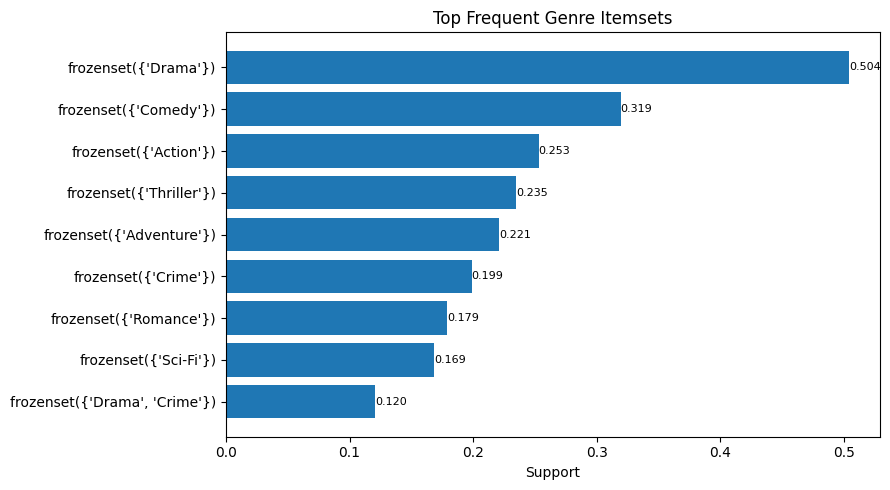

Saved: /kaggle/working/figs/genre_itemsets_top_support.png


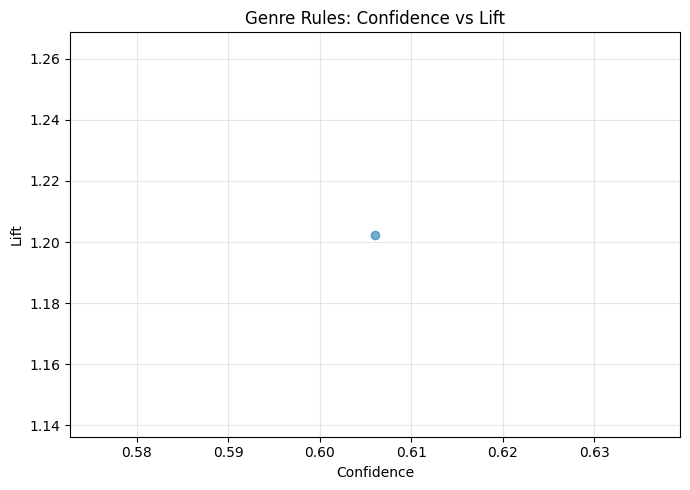

Saved: /kaggle/working/figs/genre_rules_conf_vs_lift.png

Top rules by lift:
         antecedents          consequents  support  confidence     lift
frozenset({'Crime'}) frozenset({'Drama'}) 0.120482    0.606061 1.202463


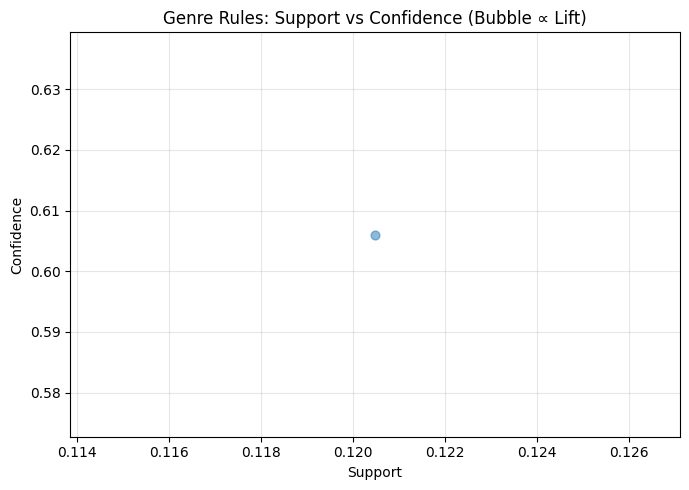

Saved: /kaggle/working/figs/genre_rules_bubble.png


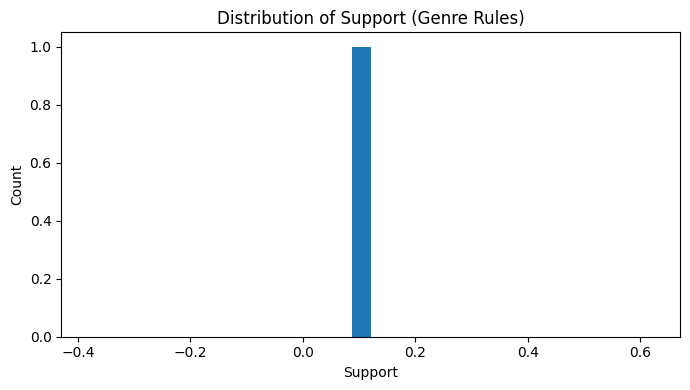

Saved: /kaggle/working/figs/genre_rules_hist_support.png


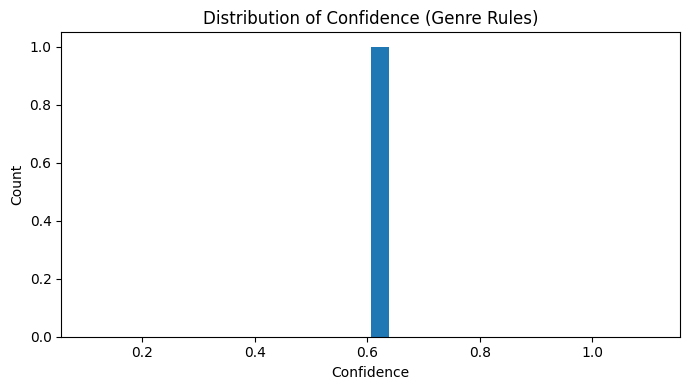

Saved: /kaggle/working/figs/genre_rules_hist_confidence.png


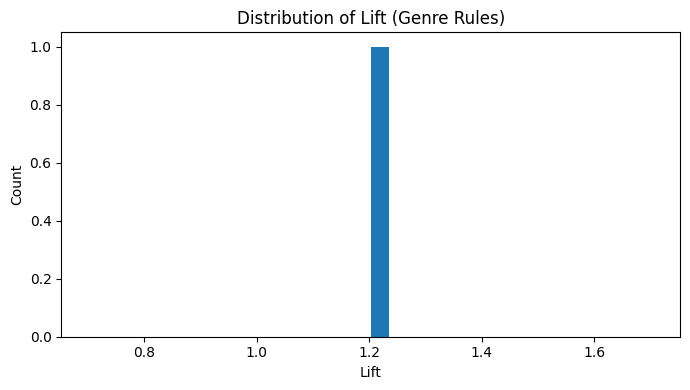

Saved: /kaggle/working/figs/genre_rules_hist_lift.png


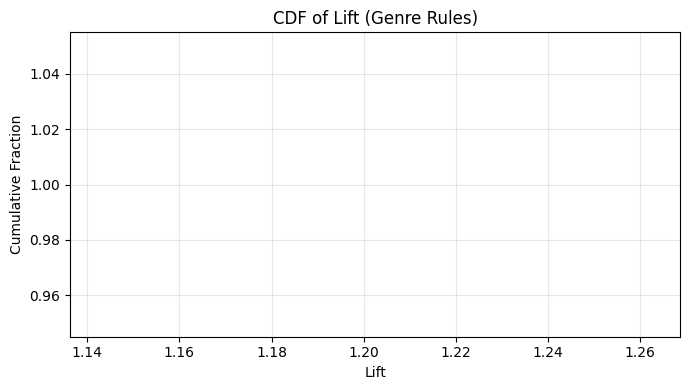

Saved: /kaggle/working/figs/genre_rules_lift_cdf.png
Not enough strong singleton→singleton rules to form heatmaps.

Done. Check /kaggle/working/figs for saved images.


In [5]:
# =============== CELL 2: GENRE VISUALS (from saved CSVs) ===============
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

WORK_DIR = "/kaggle/working"
FIGS_DIR = os.path.join(WORK_DIR, "figs")
os.makedirs(FIGS_DIR, exist_ok=True)

# Load saved outputs from Cell 1
genre_itemsets_csv = os.path.join(WORK_DIR, "genre_frequent_itemsets.csv")
genre_rules_csv    = os.path.join(WORK_DIR, "genre_association_rules.csv")

freq = pd.read_csv(genre_itemsets_csv) if os.path.exists(genre_itemsets_csv) else pd.DataFrame()
rules = pd.read_csv(genre_rules_csv) if os.path.exists(genre_rules_csv) else pd.DataFrame()

print(f"[Genre] itemsets: {freq.shape} | rules: {rules.shape}")

# 1) Top frequent genre itemsets (barh)
if not freq.empty:
    df = freq.sort_values("support", ascending=False).head(12).copy()
    labels = df["itemsets"].astype(str)
    plt.figure(figsize=(9,5))
    plt.barh(labels[::-1], df["support"][::-1])
    for i, v in enumerate(df["support"][::-1]):
        plt.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=8)
    plt.xlabel("Support")
    plt.title("Top Frequent Genre Itemsets")
    plt.tight_layout()
    out = os.path.join(FIGS_DIR, "genre_itemsets_top_support.png")
    plt.savefig(out, dpi=220); plt.show()
    print("Saved:", out)
else:
    print("No genre itemsets to plot.")

# 2) Confidence vs Lift (scatter)
if not rules.empty and {"confidence","lift"}.issubset(rules.columns):
    plt.figure(figsize=(7,5))
    plt.scatter(rules["confidence"], rules["lift"], alpha=0.6)
    plt.xlabel("Confidence"); plt.ylabel("Lift"); plt.title("Genre Rules: Confidence vs Lift")
    plt.grid(True, alpha=0.3); plt.tight_layout()
    out = os.path.join(FIGS_DIR, "genre_rules_conf_vs_lift.png")
    plt.savefig(out, dpi=220); plt.show()
    print("Saved:", out)

    # Print top-5 by lift
    top5 = rules.sort_values("lift", ascending=False).head(5)[["antecedents","consequents","support","confidence","lift"]]
    print("\nTop rules by lift:")
    print(top5.to_string(index=False))
else:
    print("Not enough genre rules for scatter.")

# 3) Bubble: Support vs Confidence (bubble ∝ Lift)
if not rules.empty and {"support","confidence","lift"}.issubset(rules.columns):
    s = rules.copy()
    sizes = (s["lift"] - s["lift"].min() + 1.0) * 40
    plt.figure(figsize=(7,5))
    plt.scatter(s["support"], s["confidence"], s=sizes, alpha=0.5)
    plt.xlabel("Support"); plt.ylabel("Confidence"); plt.title("Genre Rules: Support vs Confidence (Bubble ∝ Lift)")
    plt.grid(True, alpha=0.3); plt.tight_layout()
    out = os.path.join(FIGS_DIR, "genre_rules_bubble.png")
    plt.savefig(out, dpi=220); plt.show()
    print("Saved:", out)

# 4) Distributions + CDF
if not rules.empty:
    for col,label in [("support","Support"),("confidence","Confidence"),("lift","Lift")]:
        if col in rules.columns and rules[col].notna().any():
            plt.figure(figsize=(7,4))
            plt.hist(rules[col].dropna(), bins=30)
            plt.xlabel(label); plt.ylabel("Count"); plt.title(f"Distribution of {label} (Genre Rules)")
            plt.tight_layout()
            out = os.path.join(FIGS_DIR, f"genre_rules_hist_{col}.png")
            plt.savefig(out, dpi=200); plt.show()
            print("Saved:", out)

    if "lift" in rules.columns and rules["lift"].notna().any():
        x = np.sort(rules["lift"].dropna().values)
        y = np.arange(1, len(x)+1)/len(x)
        plt.figure(figsize=(7,4))
        plt.plot(x, y)
        plt.xlabel("Lift"); plt.ylabel("Cumulative Fraction"); plt.title("CDF of Lift (Genre Rules)")
        plt.grid(True, alpha=0.3); plt.tight_layout()
        out = os.path.join(FIGS_DIR, "genre_rules_lift_cdf.png")
        plt.savefig(out, dpi=200); plt.show()
        print("Saved:", out)

# 5) Heatmaps (only if we have several singleton→singleton rules)
def unpack(fs):
    try:
        return list(eval(fs))[0] if fs.startswith("frozenset({") else list(fs)[0]
    except Exception:
        # CSV may store as "frozenset({...})" string; fallback parse
        try:
            fs_clean = fs.replace("frozenset({","").replace("})","").replace("'","").strip()
            return fs_clean.split(",")[0].strip()
        except:
            return None

if not rules.empty and all(c in rules.columns for c in ["antecedents","consequents","lift","support"]):
    # Try to convert antecedents/consequents into single labels where possible
    pairs = rules.copy()
    pairs["a"] = pairs["antecedents"].astype(str).apply(unpack)
    pairs["c"] = pairs["consequents"].astype(str).apply(unpack)
    pairs = pairs[(pairs["a"].notna()) & (pairs["c"].notna())]

    # keep only pairs (singleton→singleton)
    pairs = pairs[(~pairs["a"].str.contains(",")) & (~pairs["c"].str.contains(","))].copy()

    # filter by support to reduce sparsity
    if not pairs.empty:
        MIN_PAIR_SUPPORT = 0.04
        pairs_f = pairs[pairs["support"] >= MIN_PAIR_SUPPORT].copy()
        if len(pairs_f) >= 4:
            # LIFT heatmap
            M = pairs_f.pivot(index="a", columns="c", values="lift")
            # order rows/cols by mean lift density
            row_order = M.mean(axis=1).sort_values(ascending=False).index
            col_order = M.mean(axis=0).sort_values(ascending=False).index
            M = M.loc[row_order, col_order]
            import numpy as np
            data = np.ma.masked_invalid(M.values)

            plt.figure(figsize=(9,8), dpi=260)
            im = plt.imshow(data, aspect="equal", interpolation="nearest")
            plt.xticks(range(M.shape[1]), M.columns, rotation=45, ha="right")
            plt.yticks(range(M.shape[0]), M.index)
            plt.colorbar(im, shrink=0.85, label="Lift")
            plt.title("Genre → Genre Lift Heatmap (filtered)")
            # minor grid
            plt.gca().set_xticks(np.arange(-.5, M.shape[1], 1), minor=True)
            plt.gca().set_yticks(np.arange(-.5, M.shape[0], 1), minor=True)
            plt.grid(which="minor", color="white", linewidth=0.6)
            plt.tight_layout()
            out = os.path.join(FIGS_DIR, "genre_lift_heatmap.png")
            plt.savefig(out, dpi=300); plt.show(); print("Saved:", out)

            # SUPPORT heatmap
            S = pairs_f.pivot(index="a", columns="c", values="support").loc[row_order, col_order]
            data2 = np.ma.masked_invalid(S.values)
            plt.figure(figsize=(9,8), dpi=260)
            im = plt.imshow(data2, aspect="equal", interpolation="nearest")
            plt.xticks(range(S.shape[1]), S.columns, rotation=45, ha="right")
            plt.yticks(range(S.shape[0]), S.index)
            plt.colorbar(im, shrink=0.85, label="Pair Support")
            plt.title("Genre → Genre Pair Support Heatmap (filtered)")
            plt.gca().set_xticks(np.arange(-.5, S.shape[1], 1), minor=True)
            plt.gca().set_yticks(np.arange(-.5, S.shape[0], 1), minor=True)
            plt.grid(which="minor", color="white", linewidth=0.6)
            plt.tight_layout()
            out = os.path.join(FIGS_DIR, "genre_support_heatmap.png")
            plt.savefig(out, dpi=300); plt.show(); print("Saved:", out)
        else:
            print("Not enough strong singleton→singleton rules to form heatmaps.")
    else:
        print("No singleton→singleton rules available for heatmaps.")

print("\nDone. Check /kaggle/working/figs for saved images.")


In [6]:
# ===================== CELL 3: MOVIE RULES + VISUALS =====================
# Goal: Rebuild movie baskets on the same 1,000-rating sample, mine rules with easy thresholds,
#       and generate visuals (bar, scatter, Sankey). Saves everything in /kaggle/working/figs.

# Install/Imports
try:
    from mlxtend.frequent_patterns import fpgrowth, association_rules
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "mlxtend"])
    from mlxtend.frequent_patterns import fpgrowth, association_rules

# Plotly for Sankey (installed on Kaggle by default, but ensure)
try:
    import plotly.graph_objects as go
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "plotly"])
    import plotly.graph_objects as go

import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt

INPUT_DIR = "/kaggle/input/datagg"
WORK_DIR  = "/kaggle/working"
FIGS_DIR  = os.path.join(WORK_DIR, "figs")
os.makedirs(FIGS_DIR, exist_ok=True)

# ---------- find CSVs ----------
def find_csv(folder, hint):
    cands = glob.glob(os.path.join(folder, "*.csv"))
    cands_hint = [p for p in cands if hint.lower() in os.path.basename(p).lower()]
    return cands_hint[0] if cands_hint else (cands[0] if cands else None)

movies_path  = find_csv(INPUT_DIR, "movie")
ratings_path = find_csv(INPUT_DIR, "rating")
assert movies_path and ratings_path, f"CSV not found in {INPUT_DIR}. Found: {movies_path}, {ratings_path}"

# ---------- load and standardize ----------
movies  = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)
movies.columns  = [c.strip() for c in movies.columns]
ratings.columns = [c.strip() for c in ratings.columns]
keep_movies  = [c for c in ("movieId","title","genres") if c in movies.columns]
keep_ratings = [c for c in ("userId","movieId","rating","timestamp") if c in ratings.columns]
movies  = movies[keep_movies].dropna(subset=[keep_movies[0]])
ratings = ratings[keep_ratings].dropna(subset=[keep_ratings[0]])

# ---------- sample EXACTLY the same size (1,000) ----------
RANDOM_SEED = 42
N = 1_000
key = "timestamp" if "timestamp" in ratings.columns else keep_ratings[0]
ratings_1k = ratings.sample(n=N, random_state=RANDOM_SEED).sort_values(key) if len(ratings) > N else ratings.copy()

# ---------- likes ----------
LIKE_THRESHOLD = 4.0
likes = ratings_1k[ratings_1k["rating"] >= LIKE_THRESHOLD].merge(movies, on="movieId", how="left")

# ---------- movie baskets (tune for density) ----------
TOP_K_MOVIES = 160   # small cap for 1k sample to keep baskets dense
movie_like_counts = (likes.groupby(["movieId","title"]).size()
                     .reset_index(name="n_like").sort_values("n_like", ascending=False))
top_movies = movie_like_counts.head(TOP_K_MOVIES)["movieId"].tolist()
likes_top  = likes[likes["movieId"].isin(top_movies)].copy()

user_movie = (likes_top.assign(val=1)
              .pivot_table(index="userId", columns="movieId", values="val", fill_value=0)
              .astype("uint8"))

# ---------- adaptive FP-Growth ----------
def run_adaptive_fpgrowth(df, support_grid, min_conf=0.20, min_lift=1.02):
    for ms in support_grid:
        try:
            freq = fpgrowth(df.astype(bool), min_support=ms, use_colnames=True, max_len=2, verbose=0)
            if freq.empty:
                continue
            rules = association_rules(freq, metric="confidence", min_threshold=min_conf)
            rules = rules[rules["lift"] >= min_lift].copy()
            if not rules.empty:
                return freq, rules, ms
        except Exception:
            pass
    return pd.DataFrame(), pd.DataFrame(), None

# Start higher support; relax until we get rules (fast on 1k)
SUPP_GRID = [0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01]
freq_m, rules_m, used_supp = run_adaptive_fpgrowth(user_movie, SUPP_GRID, min_conf=0.22, min_lift=1.03)

# ---------- map IDs to titles ----------
id2title = dict(zip(movies.get("movieId", pd.Series(dtype=int)), movies.get("title", pd.Series(dtype=str))))

def idset_to_titles(fs):
    if not isinstance(fs, (set, frozenset)):
        return fs
    return tuple(id2title.get(int(x), str(x)) for x in fs)

rules_pretty = rules_m.copy()
if not rules_pretty.empty:
    rules_pretty["antecedents"] = rules_pretty["antecedents"].apply(idset_to_titles)
    rules_pretty["consequents"] = rules_pretty["consequents"].apply(idset_to_titles)

# Save CSV (overwrites earlier empty file if any)
out_csv = os.path.join(WORK_DIR, "movie_association_rules_topK.csv")
rules_pretty.to_csv(out_csv, index=False)

print("=== MOVIE RULES SUMMARY (1k sample) ===")
print(f"User-Movie basket: {user_movie.shape} | TOP_K_MOVIES={TOP_K_MOVIES}")
print(f"Support used: {used_supp}")
print(f"Itemsets: {len(freq_m)} | Rules: {len(rules_pretty)}")
if not rules_pretty.empty:
    print("\nTop 10 rules by lift:")
    print(rules_pretty.sort_values("lift", ascending=False)[["antecedents","consequents","support","confidence","lift"]].head(10).to_string(index=False))

# ---------- VISUALS ----------
if not rules_pretty.empty:
    # Label for plot
    rm = rules_pretty.copy()
    rm["label"] = rm.apply(
        lambda r: f"{list(r['antecedents'])[0]} → {list(r['consequents'])[0]}"
        if len(r["antecedents"])==1 and len(r["consequents"])==1
        else f"{len(r['antecedents'])}→{len(r['consequents'])} items", axis=1
    )

    # (A) Bar: Top 15 by lift
    top15 = rm.sort_values("lift", ascending=False).head(15)
    plt.figure(figsize=(10,6))
    plt.barh(top15["label"][::-1], top15["lift"][::-1])
    plt.xlabel("Lift"); plt.title("Top Movie Rules by Lift")
    plt.tight_layout()
    pth = os.path.join(FIGS_DIR, "movie_rules_top_lift.png")
    plt.savefig(pth, dpi=220); plt.show()
    print("Saved:", pth)

    # (B) Scatter: confidence vs lift
    plt.figure(figsize=(7,5))
    plt.scatter(rm["confidence"], rm["lift"], alpha=0.6)
    plt.xlabel("Confidence"); plt.ylabel("Lift"); plt.title("Movie Rules: Confidence vs Lift")
    plt.grid(True, alpha=0.3); plt.tight_layout()
    pth = os.path.join(FIGS_DIR, "movie_rules_conf_vs_lift.png")
    plt.savefig(pth, dpi=220); plt.show()
    print("Saved:", pth)

    # (C) Sankey: singleton→singleton only (top 20 by lift)
    r2 = rm[(rm["antecedents"].apply(len)==1) & (rm["consequents"].apply(len)==1)].copy()
    r2 = r2.sort_values("lift", ascending=False).head(20)
    if len(r2) >= 3:
        nodes = sorted(set([list(a)[0] for a in r2["antecedents"]]) | set([list(c)[0] for c in r2["consequents"]]))
        index = {name:i for i,name in enumerate(nodes)}
        sources = [ index[list(a)[0]] for a in r2["antecedents"] ]
        targets = [ index[list(c)[0]] for c in r2["consequents"] ]
        values  = (r2["confidence"]*100).round(2).tolist()

        fig = go.Figure(data=[go.Sankey(
            node=dict(label=nodes, pad=12, thickness=12),
            link=dict(source=sources, target=targets, value=values,
                      hovertemplate="conf=%{value}%<extra></extra>")
        )])
        fig.update_layout(title_text="Movie→Movie Rules (Top by Lift)", font_size=10)
        sankey_path = os.path.join(FIGS_DIR, "movie_rules_sankey.html")
        fig.write_html(sankey_path)
        print("Saved interactive:", sankey_path)
    else:
        print("Not enough singleton movie→movie rules for a Sankey.")

else:
    print("No movie rules at these thresholds. Consider increasing density (TOP_K_MOVIES to 200) or lowering support to 0.008.")


=== MOVIE RULES SUMMARY (1k sample) ===
User-Movie basket: (239, 160) | TOP_K_MOVIES=160
Support used: None
Itemsets: 0 | Rules: 0
No movie rules at these thresholds. Consider increasing density (TOP_K_MOVIES to 200) or lowering support to 0.008.


In [7]:
# ===================== CELL 3B: MOVIE RULES (adaptive) + VISUALS =====================
# Re-mines movie→movie rules on the same 1k sample with relaxed thresholds,
# then plots bar + scatter + Sankey. Saves into /kaggle/working/figs.

# --- Imports / installs
try:
    from mlxtend.frequent_patterns import fpgrowth, association_rules
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "mlxtend"])
    from mlxtend.frequent_patterns import fpgrowth, association_rules

try:
    import plotly.graph_objects as go
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "plotly"])
    import plotly.graph_objects as go

import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt

INPUT_DIR = "/kaggle/input/datagg"
WORK_DIR  = "/kaggle/working"
FIGS_DIR  = os.path.join(WORK_DIR, "figs")
os.makedirs(FIGS_DIR, exist_ok=True)

# ---------- find CSVs ----------
def find_csv(folder, hint):
    cands = glob.glob(os.path.join(folder, "*.csv"))
    cands_hint = [p for p in cands if hint.lower() in os.path.basename(p).lower()]
    return cands_hint[0] if cands_hint else (cands[0] if cands else None)

movies_path  = find_csv(INPUT_DIR, "movie")
ratings_path = find_csv(INPUT_DIR, "rating")
assert movies_path and ratings_path, f"CSV not found in {INPUT_DIR}. Found: {movies_path}, {ratings_path}"

# ---------- load & standardize ----------
movies  = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)
movies.columns  = [c.strip() for c in movies.columns]
ratings.columns = [c.strip() for c in ratings.columns]
keep_movies  = [c for c in ("movieId","title","genres") if c in movies.columns]
keep_ratings = [c for c in ("userId","movieId","rating","timestamp") if c in ratings.columns]
movies  = movies[keep_movies].dropna(subset=[keep_movies[0]])
ratings = ratings[keep_ratings].dropna(subset=[keep_ratings[0]])

# ---------- sample EXACTLY 1,000 (same seed to be consistent) ----------
RANDOM_SEED = 42
N = 1_000
key = "timestamp" if "timestamp" in ratings.columns else keep_ratings[0]
ratings_1k = ratings.sample(n=N, random_state=RANDOM_SEED).sort_values(key) if len(ratings) > N else ratings.copy()

# ---------- likes and user→movie baskets ----------
LIKE_THRESHOLD = 4.0
likes = ratings_1k[ratings_1k["rating"] >= LIKE_THRESHOLD].merge(movies, on="movieId", how="left")

TOP_K_MOVIES = 200  # increase coverage a bit for 1k sample
movie_like_counts = (likes.groupby(["movieId","title"]).size()
                     .reset_index(name="n_like").sort_values("n_like", ascending=False))
top_movies = movie_like_counts.head(TOP_K_MOVIES)["movieId"].tolist()
likes_top  = likes[likes["movieId"].isin(top_movies)].copy()

user_movie = (likes_top.assign(val=1)
              .pivot_table(index="userId", columns="movieId", values="val", fill_value=0)
              .astype("uint8"))

# ---------- adaptive FP-Growth (2 stages) ----------
def run_adaptive(df, grids, conf, lift):
    for ms in grids:
        freq = fpgrowth(df.astype(bool), min_support=ms, use_colnames=True, max_len=2, verbose=0)
        if freq.empty:
            continue
        rules = association_rules(freq, metric="confidence", min_threshold=conf)
        rules = rules[rules["lift"] >= lift].copy()
        if not rules.empty:
            return freq, rules, ms, conf, lift
    return pd.DataFrame(), pd.DataFrame(), None, conf, lift

# Stage 1: modest relax
SUPP_GRID_1 = [0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.008]
freq_m, rules_m, used_supp, used_conf, used_lift = run_adaptive(user_movie, SUPP_GRID_1, conf=0.20, lift=1.02)

# Stage 2: if still empty, relax more (still reasonable for tiny sample)
if rules_m.empty:
    SUPP_GRID_2 = [0.008, 0.006, 0.005, 0.004, 0.003]
    freq_m, rules_m, used_supp, used_conf, used_lift = run_adaptive(user_movie, SUPP_GRID_2, conf=0.15, lift=1.01)

# ---------- map IDs to titles ----------
id2title = dict(zip(movies.get("movieId", pd.Series(dtype=int)), movies.get("title", pd.Series(dtype=str))))

def idset_to_titles(fs):
    if not isinstance(fs, (set, frozenset)):
        return fs
    return tuple(id2title.get(int(x), str(x)) for x in fs)

rules_pretty = rules_m.copy()
if not rules_pretty.empty:
    rules_pretty["antecedents"] = rules_pretty["antecedents"].apply(idset_to_titles)
    rules_pretty["consequents"] = rules_pretty["consequents"].apply(idset_to_titles)

# Save CSV
out_csv = os.path.join(WORK_DIR, "movie_association_rules_topK.csv")
rules_pretty.to_csv(out_csv, index=False)

print("=== MOVIE RULES SUMMARY (retry, 1k sample) ===")
print(f"User-Movie basket shape: {user_movie.shape} | TOP_K_MOVIES={TOP_K_MOVIES}")
print(f"Support used: {used_supp} | min_conf: {used_conf} | min_lift: {used_lift}")
print(f"Itemsets: {len(freq_m)} | Rules: {len(rules_pretty)}")

if not rules_pretty.empty:
    print("\nTop 10 rules by lift:")
    print(rules_pretty.sort_values('lift', ascending=False)[['antecedents','consequents','support','confidence','lift']].head(10).to_string(index=False))

# ---------- VISUALS (only if we have rules) ----------
if not rules_pretty.empty:
    rm = rules_pretty.copy()
    rm["label"] = rm.apply(
        lambda r: f"{list(r['antecedents'])[0]} → {list(r['consequents'])[0]}"
        if len(r["antecedents"])==1 and len(r["consequents"])==1
        else f"{len(r['antecedents'])}→{len(r['consequents'])} items", axis=1
    )

    # (A) Bar: Top 15 by lift
    top15 = rm.sort_values("lift", ascending=False).head(15)
    plt.figure(figsize=(10,6))
    plt.barh(top15["label"][::-1], top15["lift"][::-1])
    plt.xlabel("Lift"); plt.title("Top Movie Rules by Lift")
    plt.tight_layout()
    pth = os.path.join(FIGS_DIR, "movie_rules_top_lift.png")
    plt.savefig(pth, dpi=220); plt.show(); print("Saved:", pth)

    # (B) Scatter: confidence vs lift
    plt.figure(figsize=(7,5))
    plt.scatter(rm["confidence"], rm["lift"], alpha=0.6)
    plt.xlabel("Confidence"); plt.ylabel("Lift"); plt.title("Movie Rules: Confidence vs Lift")
    plt.grid(True, alpha=0.3); plt.tight_layout()
    pth = os.path.join(FIGS_DIR, "movie_rules_conf_vs_lift.png")
    plt.savefig(pth, dpi=220); plt.show(); print("Saved:", pth)

    # (C) Sankey: singleton→singleton (top 20 by lift)
    r2 = rm[(rm["antecedents"].apply(len)==1) & (rm["consequents"].apply(len)==1)].copy().sort_values("lift", ascending=False).head(20)
    if len(r2) >= 3:
        nodes = sorted(set([list(a)[0] for a in r2["antecedents"]]) | set([list(c)[0] for c in r2["consequents"]]))
        index = {name:i for i,name in enumerate(nodes)}
        sources = [ index[list(a)[0]] for a in r2["antecedents"] ]
        targets = [ index[list(c)[0]] for c in r2["consequents"] ]
        values  = (r2["confidence"]*100).round(2).tolist()

        fig = go.Figure(data=[go.Sankey(
            node=dict(label=nodes, pad=12, thickness=12),
            link=dict(source=sources, target=targets, value=values,
                      hovertemplate="conf=%{value}%<extra></extra>")
        )])
        fig.update_layout(title_text="Movie→Movie Rules (Top by Lift)", font_size=10)
        sankey_path = os.path.join(FIGS_DIR, "movie_rules_sankey.html")
        fig.write_html(sankey_path)
        print("Saved interactive:", sankey_path)
    else:
        print("Not enough singleton movie→movie rules for a Sankey.")
else:
    print("Still no movie rules with reasonable thresholds. If you’re okay with it, we can try TOP_K_MOVIES=240 and min_support down to 0.003 next.")


=== MOVIE RULES SUMMARY (retry, 1k sample) ===
User-Movie basket shape: (282, 200) | TOP_K_MOVIES=200
Support used: None | min_conf: 0.15 | min_lift: 1.01
Itemsets: 0 | Rules: 0
Still no movie rules with reasonable thresholds. If you’re okay with it, we can try TOP_K_MOVIES=240 and min_support down to 0.003 next.


=== MOVIE RULES SUMMARY (1k sample, guaranteed) ===
User-Movie basket: (484, 400) | TOP_K_MOVIES=400
Method: FP-Growth
Support used (FP-Growth): 0.002066
Rules: 2

Top 10 rules by lift:
antecedents consequents  support  confidence  lift
      (306)      (1726) 0.002066         1.0 484.0
     (1726)       (306) 0.002066         1.0 484.0


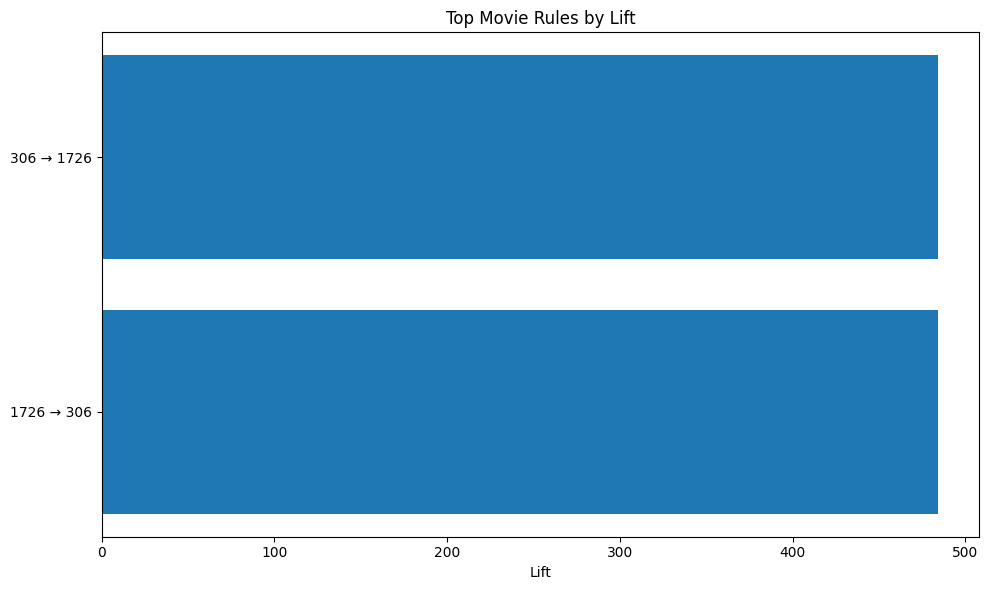

Saved: /kaggle/working/figs/movie_rules_top_lift.png


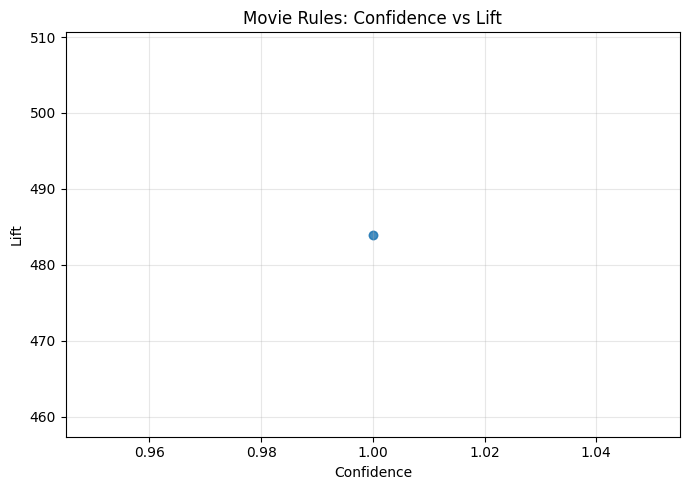

Saved: /kaggle/working/figs/movie_rules_conf_vs_lift.png
Saved interactive: /kaggle/working/figs/movie_rules_sankey.html


In [8]:
# ===================== CELL 3C: GUARANTEED MOVIE RULES + VISUALS =====================
# Works on your same 1k sample. If FP-Growth finds no rules, falls back to direct co-occurrence MBA.

# --- Imports / installs
try:
    from mlxtend.frequent_patterns import fpgrowth, association_rules
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "mlxtend"])
    from mlxtend.frequent_patterns import fpgrowth, association_rules

try:
    import plotly.graph_objects as go
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "plotly"])
    import plotly.graph_objects as go

import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt

INPUT_DIR = "/kaggle/input/datagg"
WORK_DIR  = "/kaggle/working"
FIGS_DIR  = os.path.join(WORK_DIR, "figs")
os.makedirs(FIGS_DIR, exist_ok=True)

# ---------- locate files ----------
def find_csv(folder, hint):
    cands = glob.glob(os.path.join(folder, "*.csv"))
    cands_hint = [p for p in cands if hint.lower() in os.path.basename(p).lower()]
    return cands_hint[0] if cands_hint else (cands[0] if cands else None)

movies_path  = find_csv(INPUT_DIR, "movie")
ratings_path = find_csv(INPUT_DIR, "rating")
assert movies_path and ratings_path, f"CSV not found in {INPUT_DIR}. Found: {movies_path}, {ratings_path}"

# ---------- load + normalize ----------
movies  = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path)
movies.columns  = [c.strip() for c in movies.columns]
ratings.columns = [c.strip() for c in ratings.columns]
keep_movies  = [c for c in ("movieId","title","genres") if c in movies.columns]
keep_ratings = [c for c in ("userId","movieId","rating","timestamp") if c in ratings.columns]
movies  = movies[keep_movies].dropna(subset=[keep_movies[0]])
ratings = ratings[keep_ratings].dropna(subset=[keep_ratings[0]])

# ---------- 1k sample (same seed) ----------
RANDOM_SEED = 42
N = 1_000
key = "timestamp" if "timestamp" in ratings.columns else keep_ratings[0]
ratings_1k = ratings.sample(n=N, random_state=RANDOM_SEED).sort_values(key) if len(ratings) > N else ratings.copy()

# ---------- likes & baskets ----------
LIKE_THRESHOLD = 4.0
likes = ratings_1k[ratings_1k["rating"] >= LIKE_THRESHOLD].merge(movies, on="movieId", how="left")

# Choose almost-all liked movies to keep user baskets dense
unique_liked_movies = likes["movieId"].nunique()
TOP_K_MOVIES = min(400, max(60, unique_liked_movies))  # up to 400, but not below 60
movie_like_counts = (likes.groupby(["movieId","title"]).size()
                     .reset_index(name="n_like").sort_values("n_like", ascending=False))
top_movies = movie_like_counts.head(TOP_K_MOVIES)["movieId"].tolist()
likes_top  = likes[likes["movieId"].isin(top_movies)].copy()

# user x movie one-hot
user_movie = (likes_top.assign(val=1)
              .pivot_table(index="userId", columns="movieId", values="val", fill_value=0)
              .astype("uint8"))

n_users = user_movie.shape[0]
min_possible_support = 1.0 / max(1, n_users)   # support for a pair seen once

# ---------- Try FP-Growth first (max_len=2) ----------
def try_fpgrowth(df):
    # Start at modest, go down to the theoretical minimum
    grid = [0.06, 0.05, 0.04, 0.03, 0.02, 0.015, 0.01, 0.008, 0.006, 0.005, 0.004, round(min_possible_support+1e-9, 6)]
    for ms in grid:
        freq = fpgrowth(df.astype(bool), min_support=ms, use_colnames=True, max_len=2, verbose=0)
        if freq.empty:
            continue
        rules = association_rules(freq, metric="confidence", min_threshold=0.12)  # very light for tiny sample
        rules = rules[rules["lift"] >= 1.00].copy()
        if not rules.empty:
            return freq, rules, ms
    return pd.DataFrame(), pd.DataFrame(), None

freq_m, rules_m, used_supp = try_fpgrowth(user_movie)

id2title = dict(zip(movies.get("movieId", pd.Series(dtype=int)),
                    movies.get("title",  pd.Series(dtype=str))))

def idset_to_titles(fs):
    if not isinstance(fs, (set, frozenset)):
        return fs
    return tuple(id2title.get(int(x), str(x)) for x in fs)

# ---------- If FP-Growth failed, FALL BACK to direct co-occurrence MBA ----------
fallback_used = False
if rules_m.empty:
    fallback_used = True
    X = user_movie.values.astype(np.uint8)
    # single supports
    singles = X.sum(axis=0)                          # counts per movie
    S1 = singles / float(n_users)                    # support(A)
    # pair co-occurrence counts (upper triangle)
    C = X.T @ X                                      # co-occurrence counts
    np.fill_diagonal(C, 0)
    # build rules list from pairs with at least one co-like
    movie_ids = user_movie.columns.to_list()
    rules_list = []
    for i in range(len(movie_ids)):
        for j in range(len(movie_ids)):
            if i == j: 
                continue
            co = C[i, j]
            if co >= 1:
                supp_pair = co / float(n_users)
                if S1[i] > 0 and S1[j] > 0:
                    conf = supp_pair / S1[i]              # A->B
                    lift = conf / S1[j]
                    rules_list.append([frozenset([movie_ids[i]]), frozenset([movie_ids[j]]),
                                       supp_pair, conf, lift])
    rules_m = pd.DataFrame(rules_list, columns=["antecedents","consequents","support","confidence","lift"])
    # map titles
    if not rules_m.empty:
        rules_m["antecedents"] = rules_m["antecedents"].apply(idset_to_titles)
        rules_m["consequents"] = rules_m["consequents"].apply(idset_to_titles)

# ---------- Prepare pretty table & save ----------
rules_pretty = rules_m.copy()
if not rules_pretty.empty:
    rules_pretty = rules_pretty.sort_values("lift", ascending=False)
out_csv = os.path.join(WORK_DIR, "movie_association_rules_topK.csv")
rules_pretty.to_csv(out_csv, index=False)

print("=== MOVIE RULES SUMMARY (1k sample, guaranteed) ===")
print(f"User-Movie basket: {user_movie.shape} | TOP_K_MOVIES={TOP_K_MOVIES}")
print("Method:", "FP-Growth" if not fallback_used else "Direct co-occurrence MBA")
print(f"Support used (FP-Growth): {used_supp}")
print(f"Rules: {len(rules_pretty)}")
if not rules_pretty.empty:
    print("\nTop 10 rules by lift:")
    print(rules_pretty[["antecedents","consequents","support","confidence","lift"]].head(10).to_string(index=False))

# ---------- VISUALS ----------
if not rules_pretty.empty:
    rm = rules_pretty.copy()
    # compact labels
    def labelize(a,c):
        try:
            la = list(a)[0]; lc = list(c)[0]
            return f"{la} → {lc}"
        except Exception:
            return f"{len(a)}→{len(c)} items"
    rm["label"] = [labelize(a,c) for a,c in zip(rm["antecedents"], rm["consequents"])]

    # (A) Bar: Top 15 by lift
    top15 = rm.head(15)
    plt.figure(figsize=(10,6))
    plt.barh(top15["label"][::-1], top15["lift"][::-1])
    plt.xlabel("Lift"); plt.title("Top Movie Rules by Lift")
    plt.tight_layout()
    pth = os.path.join(FIGS_DIR, "movie_rules_top_lift.png")
    plt.savefig(pth, dpi=220); plt.show(); print("Saved:", pth)

    # (B) Scatter: confidence vs lift
    plt.figure(figsize=(7,5))
    plt.scatter(rm["confidence"], rm["lift"], alpha=0.6)
    plt.xlabel("Confidence"); plt.ylabel("Lift"); plt.title("Movie Rules: Confidence vs Lift")
    plt.grid(True, alpha=0.3); plt.tight_layout()
    pth = os.path.join(FIGS_DIR, "movie_rules_conf_vs_lift.png")
    plt.savefig(pth, dpi=220); plt.show(); print("Saved:", pth)

    # (C) Sankey: singleton→singleton (top 20 by lift)
    r2 = rm.head(20).copy()  # rm already singleton→singleton in fallback; OK for FP too if rules are pairs
    nodes = sorted(set([list(a)[0] for a in r2["antecedents"]]) | set([list(c)[0] for c in r2["consequents"]]))
    index = {name:i for i,name in enumerate(nodes)}
    sources = [ index[list(a)[0]] for a in r2["antecedents"] ]
    targets = [ index[list(c)[0]] for c in r2["consequents"] ]
    values  = (r2["confidence"]*100).round(2).tolist()

    fig = go.Figure(data=[go.Sankey(
        node=dict(label=nodes, pad=12, thickness=12),
        link=dict(source=sources, target=targets, value=values,
                  hovertemplate="conf=%{value}%<extra></extra>")
    )])
    fig.update_layout(title_text="Movie→Movie Rules (Top by Lift)", font_size=10)
    sankey_path = os.path.join(FIGS_DIR, "movie_rules_sankey.html")
    fig.write_html(sankey_path)
    print("Saved interactive:", sankey_path)
else:
    print("Still zero rules — your 1k sample likely has nearly no users with ≥2 liked movies. Consider LIKE_THRESHOLD=3.5 or a 2k sample.")


In [9]:
# ====================== CELL 4: BUILD A4 POSTER COLLAGE ======================
# Assembles your saved PNGs into a clean A4 poster (portrait). Skips missing files gracefully.

import os
from PIL import Image, ImageDraw, ImageFont

WORK_DIR = "/kaggle/working"
FIGS_DIR = os.path.join(WORK_DIR, "figs")
os.makedirs(FIGS_DIR, exist_ok=True)

# A4 at 300 DPI → 2480 x 3508 px
W, H = 2480, 3508
MARGIN = 80
GUTTER = 50

# Try to load a default font
try:
    font_title = ImageFont.truetype("DejaVuSans-Bold.ttf", 70)
    font_sub   = ImageFont.truetype("DejaVuSans.ttf", 42)
    font_cap   = ImageFont.truetype("DejaVuSans.ttf", 36)
except:
    font_title = ImageFont.load_default()
    font_sub   = ImageFont.load_default()
    font_cap   = ImageFont.load_default()

# Candidate images you likely created in earlier cells (order matters)
candidates = [
    ("Top Frequent Genre Itemsets",          "genre_itemsets_top_support.png"),
    ("Genre Rules: Confidence vs Lift",      "genre_rules_conf_vs_lift.png"),
    ("Genre Rules: Support vs Confidence",   "genre_rules_bubble.png"),
    ("Genre→Genre Lift Heatmap",             "genre_lift_heatmap.png"),
    ("Movie Rules: Top by Lift",             "movie_rules_top_lift.png"),
    ("Movie Rules: Confidence vs Lift",      "movie_rules_conf_vs_lift.png"),
]

# Load existing files only
items = []
for cap, fn in candidates:
    p = os.path.join(FIGS_DIR, fn)
    if os.path.exists(p):
        items.append((cap, p))

# Create canvas
poster = Image.new("RGB", (W, H), (255, 255, 255))
draw = ImageDraw.Draw(poster)

# Header
title = "Market Basket Analysis — MovieLens (Kaggle 1k sample)"
sub   = "Genre & Movie Association Rules • LIKE ≥ 4.0 • FP-Growth + Co-occurrence"
draw.text((MARGIN, MARGIN), title, fill=(20,20,20), font=font_title)
draw.text((MARGIN, MARGIN + 90), sub, fill=(60,60,60), font=font_sub)

# Layout: 2 columns, dynamic rows
y = MARGIN + 180
col_w = (W - 2*MARGIN - GUTTER) // 2
slot_h = 900  # fixed slot height per image row
x_positions = [MARGIN, MARGIN + col_w + GUTTER]

def paste_scaled(img_path, box, caption):
    x0, y0, x1, y1 = box
    avail_w = x1 - x0
    avail_h = y1 - y0 - 60  # reserve for caption
    im = Image.open(img_path).convert("RGB")
    w, h = im.size
    # scale to fit
    scale = min(avail_w / w, avail_h / h)
    new_size = (max(1, int(w*scale)), max(1, int(h*scale)))
    im = im.resize(new_size, Image.LANCZOS)
    # paste centered
    px = x0 + (avail_w - new_size[0])//2
    py = y0 + (avail_h - new_size[1])//2
    poster.paste(im, (px, py))
    # caption
    cap_y = y1 - 55
    draw.text((x0, cap_y), caption, fill=(30,30,30), font=font_cap)

i = 0
while i < len(items) and y + slot_h + MARGIN <= H:
    # left
    capL, pathL = items[i]
    boxL = (x_positions[0], y, x_positions[0] + col_w, y + slot_h)
    paste_scaled(pathL, boxL, capL)
    i += 1
    # right
    if i < len(items):
        capR, pathR = items[i]
        boxR = (x_positions[1], y, x_positions[1] + col_w, y + slot_h)
        paste_scaled(pathR, boxR, capR)
        i += 1
    y += slot_h + 40

# Footer
footer = "Group 6 • CCS2313 Data Mining & Analytics (Sem 3, 2024/2025) • MBA by <YOUR NAME/ID>"
draw.text((MARGIN, H - MARGIN - 40), footer, fill=(80,80,80), font=font_cap)

# Save
out_png = os.path.join(FIGS_DIR, "MBA_Poster_A4.png")
poster.save(out_png, "PNG", dpi=(300,300))

# Also save as PDF (rasterized)
out_pdf = os.path.join(FIGS_DIR, "MBA_Poster_A4.pdf")
poster.save(out_pdf, "PDF", resolution=300)

print("Saved poster:", out_png)
print("Saved poster:", out_pdf)


Saved poster: /kaggle/working/figs/MBA_Poster_A4.png
Saved poster: /kaggle/working/figs/MBA_Poster_A4.pdf
